<a href="https://colab.research.google.com/github/Kurt9806/MLCEE-Project-Task7/blob/main/Copy_of_EDA_Task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_train = np.load('/content/drive/MyDrive/Machine Learning Project/task7_X_train.npy', mmap_mode='r')
data_test = np.load('/content/drive/MyDrive/Machine Learning Project/task7_X_test.npy', mmap_mode='r')
y_train = np.load('/content/drive/MyDrive/Machine Learning Project/task7_y_train.npy', mmap_mode='r')
y_test = np.load('/content/drive/MyDrive/Machine Learning Project/task7_y_test.npy', mmap_mode='r')

In [4]:
print(data_train.shape[0])

4138


# Exploratory Data Analysis

In [5]:
# Looking distribution of data
labels_train = pd.DataFrame(y_train, columns=['Heavy damage','Minor damage','Moderate damage','Undamaged'])
labels_test = pd.DataFrame(y_test, columns=['Heavy damage','Minor damage','Moderate damage','Undamaged'])

In [6]:
print(labels_test)

     Heavy damage  Minor damage  Moderate damage  Undamaged
0             1.0           0.0              0.0        0.0
1             1.0           0.0              0.0        0.0
2             1.0           0.0              0.0        0.0
3             1.0           0.0              0.0        0.0
4             1.0           0.0              0.0        0.0
..            ...           ...              ...        ...
493           0.0           0.0              0.0        1.0
494           0.0           0.0              0.0        1.0
495           0.0           0.0              0.0        1.0
496           0.0           0.0              0.0        1.0
497           0.0           0.0              0.0        1.0

[498 rows x 4 columns]


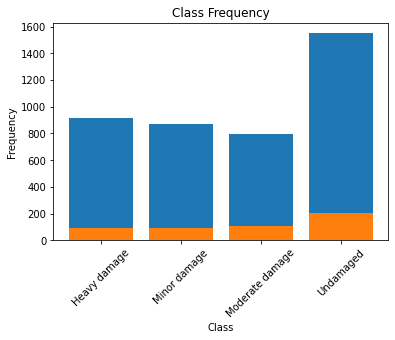

In [7]:
plt.bar(list(labels_train), labels_train.sum(axis=0))
plt.bar(list(labels_test), labels_test.sum(axis=0))

plt.title('Class Frequency')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.savefig('saved_figure-300pi.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Changing the data type
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [9]:
# Loop over each image

new_data_train = np.array([convert(data_train[i],0,255,np.uint8) for i in range(data_train.shape[0])])
new_data_test = np.array([convert(data_test[i],0,255,np.uint8) for i in range(data_test.shape[0])])

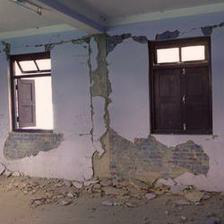

In [10]:
display(Image.fromarray(new_data_train[0]))

(224, 224, 3)


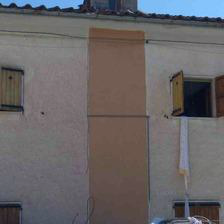

In [38]:
from keras.preprocessing.image import array_to_img
imagesize = new_data_train[0].shape
print(imagesize)
array_to_img(new_data_train[np.random.randint(len(new_data_train))][:,:,::-1])

# BaseLine


In [11]:
from tqdm import tqdm
from torchvision import transforms
from sklearn import svm
import pandas as pd

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn

In [12]:
#If there is a GPU avaiable for computations, we want to use it (else we will use a CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [175]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        """
        input: 
        'cracked_images_path': This corresponds to the path of images with cracks on your PC or Google drive
        'uncracked_images_path': This corresponds to the path of images without cracks on your PC or Google drive
        
        Output: None required (you don't need a return line)
        
        To implement: Define variables that you can use in other methods within this class. This are several ways of
        approaching this. Suggested way is to define 5 variables: self.cracked_path, self.uncracked_path,
        self.file_names_cracked, self.file_names_uncracked and self.preprocess
        
        You can obtain all filenames within a given folder using the 'glob' subroutine in python. This subroutine can
        identify all files that have a similar looking filename.
        
        self.preprocess is a composition of transforms that will preprocess a given image. Implement at least these 
        transforms: (1) Resize the images to a size that the pretrained networks (ResNet18) will accept (2) Convert the image to 
        a tensor and, (3) Normalize the tensor using the mean and standard deviation of training examples used to train the ResNet network. 
        You can get these values when you look at ResNET's documentation on the Pytorch's website.
        Refer to torchvision.transforms.compose 
        
        You can implement additional transforms that will augment your training data like random horizontal or vertical flip
        """
        #You code after this line
        self.X = np.copy(X)

        #self.X = torch.from_numpy(X.astype(np.uint8))

        #self.y = torch.from_numpy(y)
        self.y = torch.from_numpy(np.argmax(y,axis=1))

        # Transformations
        self.transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

        # Combine data
        data = []
        N = X.shape[0]
        for i in range(N):
          data.append([self.y[i].float(), self.X[i]])
        
        self.dataset = pd.DataFrame(data, columns=['Label', 'Image_array'])

    def __len__(self):
        """
        ouput: Length of the entire dataset using the variables defined in __init__ method
        """
        
        #You code after this line
        length_of_entire_dataset = self.dataset.shape[0]
        
        return length_of_entire_dataset

    def __getitem__(self, i):
        """
        Input: 'i': Integer. The ith example within the example set
        
        Output: tensor_image: Tensor of size (3,224,224) (image corresponding to the ith example).
        For a given 'i', import image using the path, filename and the Image module (from PIL library). Then use
        self.preprocess.
        
        label: Integer: '0' or '1' (0 for an uncracked image and 1 for a cracked image)
        """
        #You code after this line
        img_array = self.dataset.iloc[i, 1]
        # Open Image 
        image = Image.fromarray(img_array)

        # Extract the label
        label = self.dataset.iloc[i,0]

        # Preprocessing
        if self.transform:
          tensor_image = self.transform(image)

        return tensor_image,label

In [170]:
y_train[1000]

memmap([0., 1., 0., 0.], dtype=float32)

In [174]:
torch.from_numpy(np.argmax(y_train,axis=1))

tensor([0, 0, 0,  ..., 3, 3, 3])

In [176]:
#Do not edit this cell
#Here we are creating an insatance of the 'CEE498_Concrete_dataset' class you defined for the
#Training set
train_dataset=Dataset(new_data_train,y_train)
#This line defines a dataloader that will use the the instance 'train_dataset' and combines multiple examples 
#to form a mini batch of size 'batch_size'
train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

#Here we are creating an insatance of the 'CEE498_Concrete_dataset' class you defined for the
#Test set
test_dataset=Dataset(new_data_test,y_test)
#This line defines a dataloader that will use the the instance 'test_dataset' and combines multiple examples 
#to form a mini batch of size 'batch_size'
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [177]:
torch.from_numpy(y_test)[1]

tensor([1., 0., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.3088455
-1.9306722


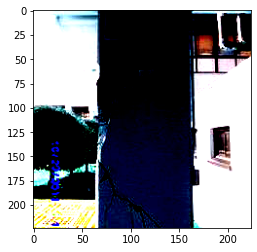

In [80]:
import matplotlib.pyplot as plt
a,b = train_dataset.__getitem__(1)
A = a.detach().numpy()
A = np.transpose(A, axes=[1,2,0])
plt.imshow(A)
print(np.max(A))
print(np.min(A))

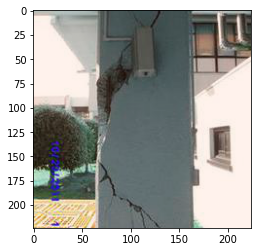

In [81]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                             std = [ 1., 1., 1. ]),])
A = invTrans(a).detach().numpy()
A = np.transpose(A, axes=[1,2,0])
plt.imshow(A)

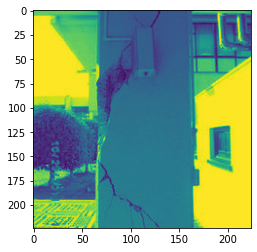

In [82]:
IMG=np.float64(A)
gray_s=np.sqrt(IMG[:,:,0]**2+IMG[:,:,1]**2+IMG[:,:,2]**2)
plt.imshow(gray_s)

In [205]:
from tqdm import tqdm
def train_classifier_one_epoch(train_data_loader, model, loss_function, optimizer,device):
    """
    Input:
    train_data_loader: Dataloader defined using an instance of 'CEE498_Concrete_dataset' corresponding to the training set
    model: Your network
    loss_function,optimizer: self explanatory
    device: cuda (0) or cpu
    
    
    output:
    loss_individual_epoch: scalar: average Loss accumulated over the entire dataset as training progresses over all minibatches
    model: Your model trainged after one epoch
    """
    model.train()
    loss_individual_epoch = 0
    for i, (images, labels) in tqdm(enumerate(train_data_loader),'Training progress within an epoch'):
        """
        Fill your code after this
        """
        optimizer.zero_grad()

        images, labels = images.to(device), labels.to(device)
        #print(labels)
        labels = labels.squeeze()
        labels = labels.float()
        
        # Make prediction
        yhat = model(images)
        #yhat = predict_cnn(yhat)
        #yhat = yhat.view(-1,4)
        
        #yhat = predict_if_crack(yhat)
        #yhat = torch.unsqueeze(yhat,1)

        #print(yhat, yhat.shape)
        #print(labels, labels.shape)

        
        # calculate the loss
        #print(yhat)
        #print(labels)
        # print(torch.max(labels,1)[1])
        loss = loss_function(yhat, labels.long())
        # calculate the gradients
        loss.backward()
        # update parameters
        optimizer.step()

        loss_individual_epoch += loss.item()

        
    return loss_individual_epoch,model

In [206]:
def train_multiple_epochs(model, num_epochs, train_dataloader, test_dataloader, loss_function, optimizer,device,test_frequency=5):
    
    """
    Input: 
    model: Your network
    num_epochs: Integer
    train_data_loader: Dataloader defined using an instance of 'CEE498_Concrete_dataset' corresponding to the training set
    test_dataloader: Dataloader defined using an instance of 'CEE498_Concrete_dataset' corresponding to the test set
    loss_function,optimizer: self explanatory
    device: cuda (0) or cpu
    test_frequency: Integer: At what frequency do you want to evaluate performance on the test set
    
    Ouput:
    model: Your model trainged after 'num_epochs' epochs
    """
    total_loss=[]
    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss,model = train_classifier_one_epoch(train_dataloader, model, loss_function, optimizer,device)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        total_loss.append(train_loss)
    return model, total_loss

# RESNET18

In [207]:
resnet18_1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print(resnet18_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [208]:
def set_requires_grad_to_false(model):
    """
    Input: 
    model: Network with requires_grad=True
    Output:
    model: Network with requires_grad=False
    """
    #You code after this line
    for param in model.parameters():
      param.requires_grad = False
    return model

In [209]:
#resnet18_1=set_requires_grad_to_false(resnet18_1)
print(resnet18_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [210]:
#Implement the above in this cell
resnet18_1.fc = nn.Sequential(nn.Linear(512, 4))
#Change the grad to true
#resnet18_1.fc2.weight.requires_grad = False
#resnet18_1.fc2.bias.requires_grad = False
#Do not remove this
resnet18_1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [211]:
train_dataset.__len__()

4138

In [212]:
test_dataset.__len__()

498

In [213]:
loss_function=nn.CrossEntropyLoss()#Choose a loss function you wish to optimize in this excersise
learning_rate=0.005 #Choose a learning rate
optimizer=torch.optim.SGD(resnet18_1.parameters(), lr=learning_rate)#Choose an optimizer you wish
number_of_epochs=10#Choose the number of epochs
test_frequency=2 #(how often do you want to display performance on the test data)
resnet18_1, total_loss=train_multiple_epochs(resnet18_1, number_of_epochs, train_dataloader, test_dataloader, loss_function, optimizer,device,test_frequency)

Starting epoch number 1


Training progress within an epoch: 414it [00:19, 21.02it/s]


Loss for Training on Epoch 1 is 426.5045084655285
Starting epoch number 2


Training progress within an epoch: 414it [00:19, 21.15it/s]


Loss for Training on Epoch 2 is 314.91264970600605
Starting epoch number 3


Training progress within an epoch: 414it [00:19, 21.02it/s]


Loss for Training on Epoch 3 is 252.85636115074158
Starting epoch number 4


Training progress within an epoch: 414it [00:19, 21.02it/s]


Loss for Training on Epoch 4 is 194.0769851654768
Starting epoch number 5


Training progress within an epoch: 414it [00:19, 21.06it/s]


Loss for Training on Epoch 5 is 137.6843341626227
Starting epoch number 6


Training progress within an epoch: 414it [00:19, 21.08it/s]


Loss for Training on Epoch 6 is 99.04624966159463
Starting epoch number 7


Training progress within an epoch: 414it [00:19, 21.02it/s]


Loss for Training on Epoch 7 is 81.29529938753694
Starting epoch number 8


Training progress within an epoch: 414it [00:19, 21.04it/s]


Loss for Training on Epoch 8 is 67.18805397255346
Starting epoch number 9


Training progress within an epoch: 414it [00:19, 21.11it/s]


Loss for Training on Epoch 9 is 51.25475680967793
Starting epoch number 10


Training progress within an epoch: 414it [00:19, 20.96it/s]

Loss for Training on Epoch 10 is 47.955235860310495


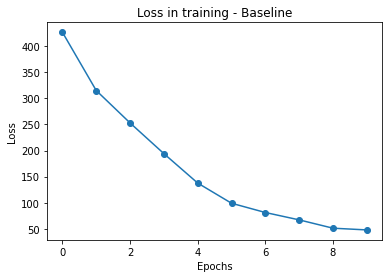

In [214]:
plt.plot(np.array(total_loss),marker='o')
plt.title('Loss in training - Baseline')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png', dpi=300, bbox_inches='tight')

In [215]:
def predict_cnn(output_final_layer):
    """
    Input: 
    ouput_final_layer: Numpy ouput from the network (convert the tensor into a numpy array before sending it as an input to 
    this function): Shape (N,a) where 'N' is number of examples and 'a' depends on
    the network (either 1 or 2)
    
    prediction: numpy array: shape: (N,) (0 for no crack or 1 for cracked imaged)
    """
    #You code after this line
    i, prediction = torch.max(torch.exp(output_final_layer),1)
    print(i)

    return prediction


In [216]:
def test_classifier(test_dataloader, model):
    model.eval()
    with torch.no_grad():
        """
        Input:
        use the 'predict_if_crack' in this to help you
        test_dataloader: Dataloader defined using an instance of 'CEE498_Concrete_dataset' corresponding to the test set
        model: Trained network to be tested
        
        Ouput: No return statement required
        """
        y_true = []
        y_predict = []
        for i, (images, labels) in enumerate(test_dataloader):
            #You code after this line
            images, labels = images.to(device), labels.to(device)
            y_true.extend(labels.data.cpu().numpy())
            z = model(images)
            yhat = (torch.max((z),1)[1]).data.cpu().numpy()
            #print(torch.exp(z))
            y_predict.extend(yhat)

    return y_predict, y_true

In [217]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_predict, y_true = test_classifier(test_dataloader,resnet18_1) 
cm = confusion_matrix(y_true, y_predict)
print(cm)

print(classification_report(y_true,y_predict))

[[ 66   2  16  10]
 [  4  55  13  21]
 [ 21  15  49  19]
 [  2  18  13 174]]
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71        94
         1.0       0.61      0.59      0.60        93
         2.0       0.54      0.47      0.50       104
         3.0       0.78      0.84      0.81       207

    accuracy                           0.69       498
   macro avg       0.66      0.65      0.65       498
weighted avg       0.68      0.69      0.69       498



In [218]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix_pytorch(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 66   2  16  10]
 [  4  55  13  21]
 [ 21  15  49  19]
 [  2  18  13 174]]


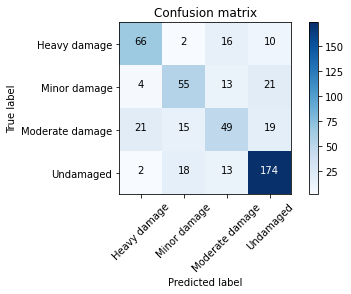

In [219]:
plot_confusion_matrix_pytorch(cm, labels_test.columns.to_numpy())

# VGG16

In [220]:
import torchvision
VGG16_1 = torchvision.models.vgg16(pretrained=True)
print(VGG16_1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [221]:
# Change last layer
VGG16_1.fc = nn.Sequential(nn.Linear(1000, 4), nn.LogSoftmax(dim=1))

#Do not remove this
VGG16_1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
loss_function=nn.CrossEntropyLoss()#Choose a loss function you wish to optimize in this excersise
learning_rate=0.005 #Choose a learning rate
optimizer=torch.optim.SGD(VGG16_1.parameters(), lr=learning_rate)#Choose an optimizer you wish
number_of_epochs=10#Choose the number of epochs
test_frequency=2 #(how often do you want to display performance on the test data)
VGG16_1, total_loss=train_multiple_epochs(VGG16_1, number_of_epochs, train_dataloader, test_dataloader, loss_function, optimizer,device,test_frequency)

Starting epoch number 1


Training progress within an epoch: 414it [00:53,  7.80it/s]


Loss for Training on Epoch 1 is 20.49869256034927
Starting epoch number 2


Training progress within an epoch: 414it [00:53,  7.80it/s]


Loss for Training on Epoch 2 is 0.000511174540498871
Starting epoch number 3


Training progress within an epoch: 414it [00:50,  8.14it/s]


Loss for Training on Epoch 3 is 0.00017769866407135737
Starting epoch number 4


Training progress within an epoch: 414it [00:50,  8.24it/s]


Loss for Training on Epoch 4 is 0.0001362271246145852
Starting epoch number 5


Training progress within an epoch: 414it [00:49,  8.32it/s]


Loss for Training on Epoch 5 is 0.00586886784973828
Starting epoch number 6


Training progress within an epoch: 414it [00:49,  8.33it/s]


Loss for Training on Epoch 6 is 0.00020065956641523996
Starting epoch number 7


Training progress within an epoch: 414it [00:49,  8.33it/s]


Loss for Training on Epoch 7 is 0.00013807734099025026
Starting epoch number 8


Training progress within an epoch: 414it [00:49,  8.33it/s]


Loss for Training on Epoch 8 is 0.00019981799002444234
Starting epoch number 9


Training progress within an epoch: 414it [00:49,  8.32it/s]


Loss for Training on Epoch 9 is 0.00037949008712701016
Starting epoch number 10


Training progress within an epoch: 414it [00:49,  8.32it/s]

Loss for Training on Epoch 10 is 0.00017279984254514602


Text(0, 0.5, 'Loss')

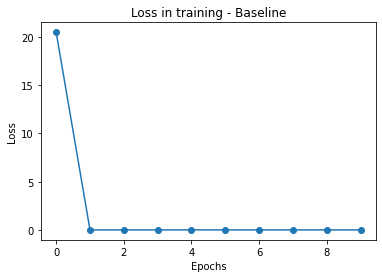

In [55]:
plt.plot(np.array(total_loss),marker='o')
plt.title('Loss in training - Baseline')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('loss.png', dpi=300, bbox_inches='tight')

## Testing

In [53]:
# Confussion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_predict, y_true = test_classifier(test_dataloader,VGG16_1) 
cm = confusion_matrix(y_true, y_predict)
print(cm)
print(classification_report(y_true,y_predict))

[[ 94   0   0   0]
 [ 93   0   0   0]
 [104   0   0   0]
 [207   0   0   0]]
              precision    recall  f1-score   support

         0.0       0.19      1.00      0.32        94
         1.0       0.00      0.00      0.00        93
         2.0       0.00      0.00      0.00       104
         3.0       0.00      0.00      0.00       207

    accuracy                           0.19       498
   macro avg       0.05      0.25      0.08       498
weighted avg       0.04      0.19      0.06       498



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[ 94   0   0   0]
 [ 93   0   0   0]
 [104   0   0   0]
 [207   0   0   0]]


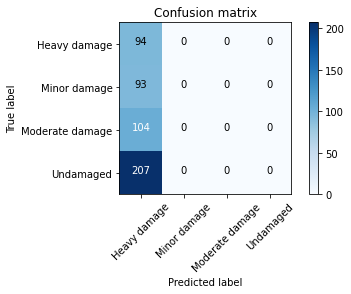

In [54]:
plot_confusion_matrix_pytorch(cm, labels_test.columns.to_numpy())